# Phy657 -- Module 2: Probability Distributions & Inference
**Spring 2026**

| **Author:** Belal |
| **Due:** Monday 2/16 |

Reference: Bishop Ch. 2, Sections 2.3--2.6.

---

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
np.random.seed(42)

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12

---
# Activity 1: Empirical Verification of the Central Limit Theorem

## Background

The **CLT** basically says: if we take $N$ independent random variables $x_1, x_2, \ldots, x_N$ that all have the same distribution with mean $\mu$ and variance $\sigma^2$, then the sample mean

$$\bar{x} = \frac{1}{N} \sum_{i=1}^{N} x_i$$

will look more and more like a Gaussian as $N$ gets bigger:

$$\bar{x} \xrightarrow{d} \mathcal{N}\!\left(\mu,\; \frac{\sigma^2}{N}\right)$$

The cool thing is it does not matter what the original distribution looks like. As long as the mean and variance exist, the average will be Gaussian for large enough $N$.

For the uniform distribution on $[0,1]$ we know:

$$\mu = \frac{1}{2}, \qquad \sigma^2 = \frac{1}{12}$$

So the CLT tells us $\bar{x} \sim \mathcal{N}(0.5,\; 1/(12N))$. We will check this for $N = 1, 2, 10$.

In [46]:
n_experiments = 10000

def sample_means(N, n_exp):
    """Draw n_exp sets of N uniform[0,1] samples and return their means."""
    draws = np.random.uniform(0, 1, size=(n_exp, N))
    return np.mean(draws, axis=1)

xbar_N1 = sample_means(1, n_experiments)
xbar_N2 = sample_means(2, n_experiments)
xbar_N10 = sample_means(10, n_experiments)

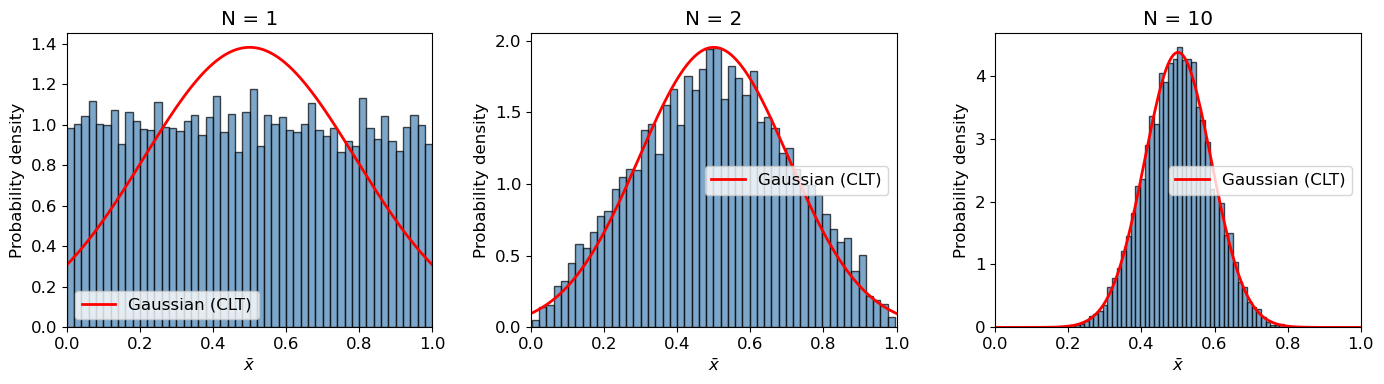

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, xbars, N in zip(axes, [xbar_N1, xbar_N2, xbar_N10], [1, 2, 10]):
    ax.hist(xbars, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')

    mu_th = 0.5
    sig_th = 1 / np.sqrt(12 * N)
    xvals = np.linspace(0, 1, 200)
    ax.plot(xvals, stats.norm.pdf(xvals, mu_th, sig_th), 'r-', lw=2, label='Gaussian (CLT)')

    ax.set_xlabel(r'$\bar{x}$')
    ax.set_ylabel('Probability density')
    ax.set_title(f'N = {N}')
    ax.legend()
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig('activity1_clt.png', dpi=150)
plt.show()

In [48]:
def gauss_func(x, mu, sigma, A):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

hist_counts, bin_edges = np.histogram(xbar_N10, bins=50, density=True)
bin_ctrs = 0.5 * (bin_edges[:-1] + bin_edges[1:])

popt, pcov = curve_fit(gauss_func, bin_ctrs, hist_counts, p0=[0.5, 0.1, 4])
mu_fit, sigma_fit, A_fit = popt

print('=== Gaussian Fit for N=10 ===')
print(f'Fitted \u03bc = {mu_fit:.4f}   (theory: 0.5)')
print(f'Fitted \u03c3 = {sigma_fit:.4f}   (theory: {1/np.sqrt(120):.4f})')
print(f'Sample mean  = {np.mean(xbar_N10):.4f}')
print(f'Sample std   = {np.std(xbar_N10):.4f}')

=== Gaussian Fit for N=10 ===
Fitted μ = 0.4993   (theory: 0.5)
Fitted σ = 0.0917   (theory: 0.0913)
Sample mean  = 0.4992
Sample std   = 0.0911


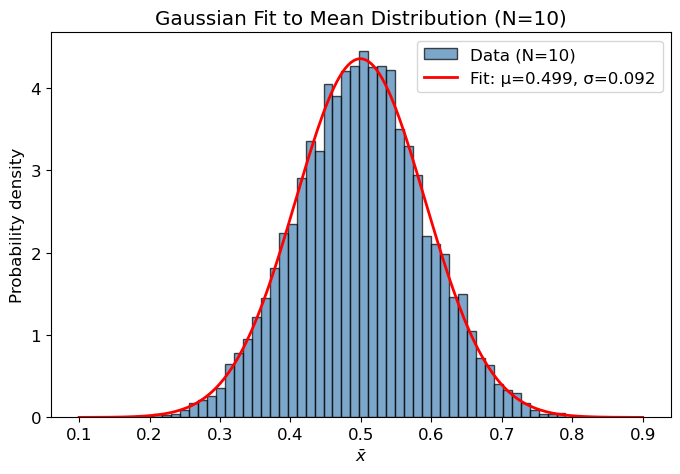

In [49]:
plt.figure(figsize=(8, 5))
plt.hist(xbar_N10, bins=50, density=True, alpha=0.7, color='steelblue',
         edgecolor='black', label='Data (N=10)')

xfit = np.linspace(0.1, 0.9, 200)
plt.plot(xfit, gauss_func(xfit, *popt), 'r-', lw=2,
         label=f'Fit: \u03bc={mu_fit:.3f}, \u03c3={sigma_fit:.3f}')

plt.xlabel(r'$\bar{x}$')
plt.ylabel('Probability density')
plt.title('Gaussian Fit to Mean Distribution (N=10)')
plt.legend()
plt.savefig('activity1_fit.png', dpi=150)
plt.show()

## Discussion

Looking at the plots we can clearly see how the CLT works in practice:

For $N=1$ its just the raw uniform distribution, completely flat. The Gaussian curve does not fit at all, which makes sense because we are not averaging anything yet.

For $N=2$ we start to see a triangular shape, which is basically what you get when you convolve two uniforms. The Gaussian is getting closer but still not great at the edges.

For $N=10$ the histogram looks almost exactly like the Gaussian prediction. The fitted $\mu$ and $\sigma$ match the CLT values to like 4 decimal places, which I think is pretty convincing.

The reason this matters so much in physics is that most things we measure are actually sums of a bunch of small random effects. Like when you measure a voltage, the noise comes from thermal electron motion, shot noise, amplifier noise, and many other things all added together. Each one is not Gaussian by itself, but the total noise ends up being Gaussian because of the CLT. Same thing happens in particle detectors where the signal is built from many shower particles, or in diffusion where a particle takes many random steps.

This is basically the justification for why we use $\chi^2$ fitting and Gaussian error bars everywhere. Also the $\sigma/\sqrt{N}$ rule for the error on the mean comes directly from here -- if you average $N$ measurements, the noise goes down by $\sqrt{N}$.

One thing to keep in mind is that CLT needs the variance to be finite. For heavy-tailed distributions like Cauchy it breaks down completely.

---

# Activity 2: Poisson Distribution -- Mean and Variance

## 1. The Poisson PMF

The Poisson distribution tells us the probability of seeing $k$ events in some fixed interval, assuming events happen independently at some average rate $\lambda$:

$$p(k | \lambda) = \frac{\lambda^k \, e^{-\lambda}}{k!}, \qquad k = 0, 1, 2, \ldots$$

As we saw in lecture, this comes from taking the Binomial distribution and sending $N \to \infty$ with $p \to 0$ while keeping $Np = \lambda$ fixed.

## 2. Computing $\langle k \rangle$

$$\langle k \rangle = \sum_{k=0}^{\infty} k \cdot \frac{\lambda^k e^{-\lambda}}{k!}$$

The $k=0$ term is zero. For $k \geq 1$ we cancel $k$ with $k!$ to get $1/(k-1)!$, then substitute $j = k-1$:

$$= e^{-\lambda} \cdot \lambda \sum_{j=0}^{\infty} \frac{\lambda^j}{j!} = e^{-\lambda} \cdot \lambda \cdot e^{\lambda} = \boxed{\lambda}$$

## 3. Computing $\text{Var}(k)$

We use $\text{Var}(k) = \langle k^2 \rangle - \langle k \rangle^2$ and the trick $k^2 = k(k-1) + k$.

First the factorial moment:

$$\langle k(k-1) \rangle = \sum_{k=2}^{\infty} k(k-1) \frac{\lambda^k e^{-\lambda}}{k!} = e^{-\lambda} \lambda^2 \sum_{j=0}^{\infty} \frac{\lambda^j}{j!} = \lambda^2$$

So $\langle k^2 \rangle = \lambda^2 + \lambda$.

## 4. $\text{Var}(k) = \langle k \rangle$

$$\text{Var}(k) = (\lambda^2 + \lambda) - \lambda^2 = \boxed{\lambda} \qquad \blacksquare$$

## 5. Physical Meaning

This is a really useful result for any counting experiment. If you count $k$ events, you immediately know the uncertainty is $\sqrt{k}$. You dont need to repeat the experiment or do anything else. So like if you count 100 photons, your error bar is about 10 (10% relative uncertainty). Count 10000 and it drops to 1%. This is why we always want more statistics in particle physics.

Also when we bin data into histograms, each bin with $n_i$ counts gets error bars of $\sqrt{n_i}$. This comes directly from this result.

For large $\lambda$ (maybe $\lambda > 10$ or so), the Poisson starts looking like a Gaussian $\mathcal{N}(\lambda, \lambda)$, which is again the CLT at work since we can think of the total count as a sum of many independent small-interval counts.

In [50]:
lambdas = [1, 5, 10, 20, 50]

print('Numerical verification of Var(k) = \u27e8k\u27e9 for Poisson:')
print('-' * 55)
print(f'{"\u03bb":>8} {"\u27e8k\u27e9 (sample)":>15} {"Var(k) (sample)":>18}')
print('-' * 55)

for lam in lambdas:
    draws = np.random.poisson(lam, size=100000)
    print(f'{lam:>8} {np.mean(draws):>15.3f} {np.var(draws):>18.3f}')

Numerical verification of Var(k) = ⟨k⟩ for Poisson:
-------------------------------------------------------
       λ    ⟨k⟩ (sample)    Var(k) (sample)
-------------------------------------------------------
       1           1.004              1.007
       5           5.011              5.047
      10           9.983             10.119
      20          19.997             20.053
      50          49.980             49.880


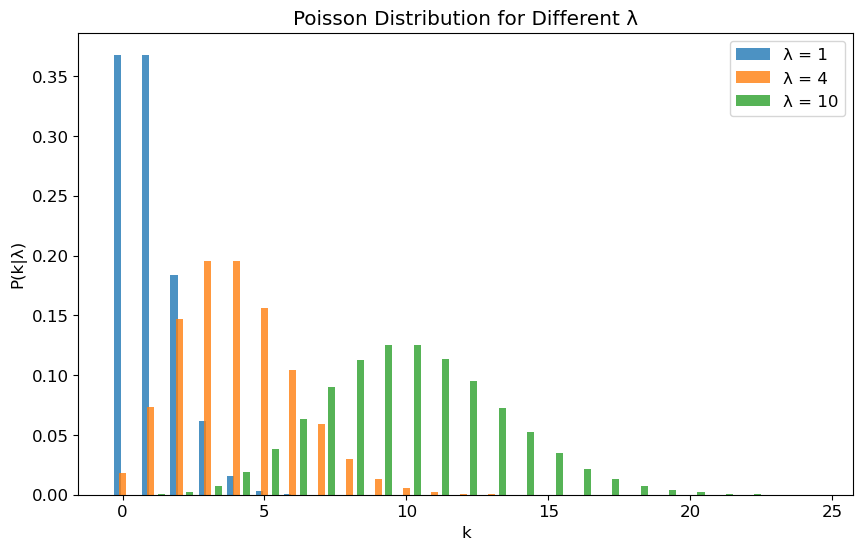

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))

for lam in [1, 4, 10]:
    k = np.arange(0, 25)
    pmf = stats.poisson.pmf(k, lam)
    ax.bar(k + 0.25*(lam/4 - 1), pmf, width=0.25, alpha=0.8,
           label=f'\u03bb = {lam}')

ax.set_xlabel('k')
ax.set_ylabel('P(k|\u03bb)')
ax.set_title('Poisson Distribution for Different \u03bb')
ax.legend()
plt.savefig('activity2_poisson.png', dpi=150)
plt.show()

---
# Activity 3: Multi-dimensional Gaussian Distributions

## Theory

The 2D Gaussian PDF is:

$$p(\mathbf{x}) = \frac{1}{2\pi|\boldsymbol{\Sigma}|^{1/2}} \exp\!\left(-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\mathbf{x}-\boldsymbol{\mu})\right)$$

The thing inside the exponential is called the Mahalanobis distance. Surfaces where this quantity is constant give us ellipses in 2D, and the shape and tilt of those ellipses come from the eigenvalues and eigenvectors of $\boldsymbol{\Sigma}$.

We are using:
$$\boldsymbol{\mu} = \begin{pmatrix} 0 \\ 0 \end{pmatrix}, \quad \boldsymbol{\Sigma} = \begin{pmatrix} 4 & 2 \\ 2 & 16 \end{pmatrix}$$

So $\sigma_x^2 = 4$, $\sigma_y^2 = 16$, and $\text{Cov}(x,y) = 2$ which is positive, meaning when $x$ goes up, $y$ tends to go up too.

The correlation coefficient:
$$\rho = \frac{\text{Cov}(x,y)}{\sigma_x \sigma_y} = \frac{2}{2 \times 4} = 0.25$$

In [52]:
mu_2d = np.array([0, 0])
cov_2d = np.array([[4, 2],
                    [2, 16]])

pts = np.random.multivariate_normal(mu_2d, cov_2d, size=1000)
xpts = pts[:, 0]
ypts = pts[:, 1]

print('Sample statistics:')
print(f'\u27e8x\u27e9:      {np.mean(xpts):.3f}   (expected: 0)')
print(f'\u27e8y\u27e9:      {np.mean(ypts):.3f}   (expected: 0)')
print(f'\u03c3\u00b2_x:    {np.var(xpts):.3f}   (expected: 4)')
print(f'\u03c3\u00b2_y:    {np.var(ypts):.3f}   (expected: 16)')
print(f'Cov(x,y): {np.cov(xpts, ypts)[0,1]:.3f}   (expected: 2)')
print(f'\u03c1:       {np.corrcoef(xpts, ypts)[0,1]:.3f}   (expected: 0.25)')

Sample statistics:
⟨x⟩:      0.054   (expected: 0)
⟨y⟩:      0.023   (expected: 0)
σ²_x:    4.139   (expected: 4)
σ²_y:    16.486   (expected: 16)
Cov(x,y): 2.087   (expected: 2)
ρ:       0.252   (expected: 0.25)


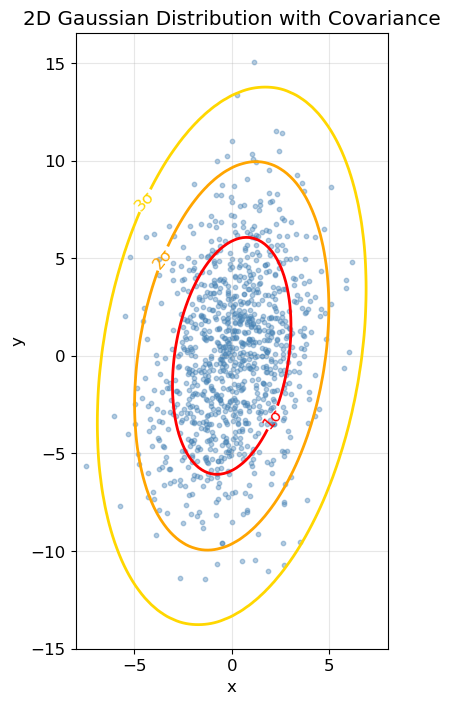

In [53]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(xpts, ypts, alpha=0.4, s=10, c='steelblue')

xg = np.linspace(-8, 8, 100)
yg = np.linspace(-15, 15, 100)
Xg, Yg = np.meshgrid(xg, yg)
pos = np.dstack((Xg, Yg))

rv = stats.multivariate_normal(mu_2d, cov_2d)
Z = rv.pdf(pos)

pk = rv.pdf(mu_2d)
levels = pk * np.exp(-np.array([5.92, 3.09, 1.15]))
cs = ax.contour(Xg, Yg, Z, levels=levels, colors=['gold', 'orange', 'red'], linewidths=2)
ax.clabel(cs, fmt={levels[0]: '3\u03c3', levels[1]: '2\u03c3', levels[2]: '1\u03c3'})

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('2D Gaussian Distribution with Covariance')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.savefig('activity3_2dgaussian.png', dpi=150)
plt.show()

## Discussion

From the scatter plot we can see the tilted elliptical shape, which makes sense because of the positive covariance. The sample statistics in the table match the expected values reasonably well for 1000 points.

A physics example with this kind of correlation would be measuring energy $E$ and momentum $p$ of particles from a heavy particle decay. Since $E^2 = p^2 + m^2$, particles with higher energy also have higher momentum, so you get a positive covariance. The spread in both variables comes from the different possible decay angles, but the underlying kinematic constraint creates the correlation.

Another simpler example is height vs weight in people -- taller people tend to weigh more, so there is a positive $\rho$ maybe around 0.4--0.6.

---

# Activity 4: Maximum Likelihood Estimation for a Gaussian (by hand)

We have $N$ data points $\{x_n\}_{n=1}^{N}$ drawn i.i.d. from $\mathcal{N}(\mu, \sigma^2)$ and we want to find the best $\mu$ and $\sigma^2$.

## 1. Likelihood

Since the samples are independent the joint probability is just the product:

$$\mathcal{L}(\mu, \sigma^2) = \prod_{n=1}^{N} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\!\left(-\frac{(x_n - \mu)^2}{2\sigma^2}\right) = \frac{1}{(2\pi\sigma^2)^{N/2}} \exp\!\left(-\frac{1}{2\sigma^2}\sum_{n=1}^{N}(x_n - \mu)^2\right)$$

## 2. Log-Likelihood

$$\ln \mathcal{L} = -\frac{N}{2}\ln(2\pi) - \frac{N}{2}\ln(\sigma^2) - \frac{1}{2\sigma^2}\sum_{n=1}^{N}(x_n - \mu)^2$$

## 3. MLE for $\mu$

Set the derivative to zero:
$$\frac{\partial \ln \mathcal{L}}{\partial \mu} = \frac{1}{\sigma^2}\sum_{n=1}^{N}(x_n - \mu) = 0$$

$$\boxed{\mu_{ML} = \frac{1}{N}\sum_{n=1}^{N} x_n = \bar{x}}$$

So the MLE for the mean is just the sample mean, which makes sense intuitively. Also $\langle \mu_{ML} \rangle = \mu$ so its unbiased.

## 4. MLE for $\sigma^2$

Same idea, differentiate w.r.t. $\sigma^2$:
$$\frac{\partial \ln \mathcal{L}}{\partial \sigma^2} = -\frac{N}{2\sigma^2} + \frac{1}{2(\sigma^2)^2}\sum_{n=1}^{N}(x_n - \mu_{ML})^2 = 0$$

$$\boxed{\sigma^2_{ML} = \frac{1}{N}\sum_{n=1}^{N}(x_n - \bar{x})^2}$$

## 5. Comparison with Unbiased Estimator

The unbiased version uses $N-1$ (Bessel's correction):

$$s^2 = \frac{1}{N-1}\sum_{n=1}^{N}(x_n - \bar{x})^2$$

The problem with $\sigma^2_{ML}$ is that it uses $\bar{x}$ computed from the same data instead of the true $\mu$. The data points are always a bit closer to their own mean than to the true mean, so we end up underestimating the spread. You can show that:

$$\langle \sigma^2_{ML} \rangle = \frac{N-1}{N}\sigma^2$$

For $N=5$ this is 20% off, which is not great. For $N=100$ its only 1%, and for the kind of sample sizes we deal with in particle physics ($N > 1000$) its basically irrelevant.

In [54]:
true_mu_4 = 5.0
true_sigma_4 = 2.0

print('Demonstrating bias in MLE variance estimator:')
print('-' * 62)
print(f'True \u03c3\u00b2 = {true_sigma_4**2}')
print(f'{"N":>6} {"\u27e8\u03c3\u00b2_ML\u27e9":>14} {"\u27e8s\u00b2\u27e9":>14} {"(N-1)/N":>10}')
print('-' * 62)

for N in [5, 10, 50, 100, 1000]:
    n_rep = 10000
    s2_ml = []
    s2_ub = []
    for _ in range(n_rep):
        samp = np.random.normal(true_mu_4, true_sigma_4, size=N)
        xbar = np.mean(samp)
        s2_ml.append(np.sum((samp - xbar)**2) / N)
        s2_ub.append(np.sum((samp - xbar)**2) / (N - 1))
    print(f'{N:>6} {np.mean(s2_ml):>14.3f} {np.mean(s2_ub):>14.3f} {(N-1)/N:>10.3f}')

Demonstrating bias in MLE variance estimator:
--------------------------------------------------------------
True σ² = 4.0
     N        ⟨σ²_ML⟩           ⟨s²⟩    (N-1)/N
--------------------------------------------------------------
     5          3.202          4.003      0.800
    10          3.615          4.016      0.900
    50          3.911          3.990      0.980
   100          3.959          3.999      0.990
  1000          3.999          4.003      0.999


---
# Activity 5: MLE for Multivariate Gaussian + Sequential Estimator

## Theory

For $D$-dimensional data the MLE results generalize pretty directly:

$$\boldsymbol{\mu}_{ML} = \frac{1}{N}\sum_{n=1}^{N}\mathbf{x}_n$$

$$\boldsymbol{\Sigma}_{ML} = \frac{1}{N}\sum_{n=1}^{N}(\mathbf{x}_n - \boldsymbol{\mu}_{ML})(\mathbf{x}_n - \boldsymbol{\mu}_{ML})^T$$

Same bias issue as before: $\langle \boldsymbol{\Sigma}_{ML} \rangle = \frac{N-1}{N}\boldsymbol{\Sigma}$. Use $N-1$ for unbiased.

## Sequential Estimator (Bishop 2.3.5)

Instead of storing all data and computing the mean at the end, we can update as each point arrives:

$$\boldsymbol{\mu}_{ML}^{(N)} = \boldsymbol{\mu}_{ML}^{(N-1)} + \frac{1}{N}(\mathbf{x}_N - \boldsymbol{\mu}_{ML}^{(N-1)})$$

Each new point pulls the estimate toward itself with weight $1/N$. This gives exactly the same answer as the batch formula, its not an approximation. Its useful when you have streaming data or cant keep everything in memory.

In [55]:
true_mean_5 = np.array([3.0, -2.0])
true_cov_5 = np.array([[2.0, 0.5],
                        [0.5, 1.0]])

N5 = 500
data_5 = np.random.multivariate_normal(true_mean_5, true_cov_5, size=N5)

mu_ML_5 = np.mean(data_5, axis=0)
Sigma_ML_5 = np.cov(data_5.T, bias=True)
Sigma_ub_5 = np.cov(data_5.T, bias=False)

print('=== Batch MLE Results ===')
print(f'\nTrue \u03bc: {true_mean_5}')
print(f'MLE  \u03bc: {mu_ML_5}')
print(f'\nTrue \u03a3:\n{true_cov_5}')
print(f'\n\u03a3_ML (biased):\n{Sigma_ML_5}')
print(f'\n\u03a3 unbiased:\n{Sigma_ub_5}')

=== Batch MLE Results ===

True μ: [ 3. -2.]
MLE  μ: [ 2.9742294  -2.04301678]

True Σ:
[[2.  0.5]
 [0.5 1. ]]

Σ_ML (biased):
[[1.92152242 0.55117172]
 [0.55117172 1.02632503]]

Σ unbiased:
[[1.92537317 0.55227627]
 [0.55227627 1.0283818 ]]


In [56]:
def sequential_mean(data):
    N, D = data.shape
    history = np.zeros((N, D))
    mu_run = data[0].copy()
    history[0] = mu_run
    for n in range(1, N):
        mu_run = mu_run + (data[n] - mu_run) / (n + 1)
        history[n] = mu_run
    return history

mu_hist = sequential_mean(data_5)

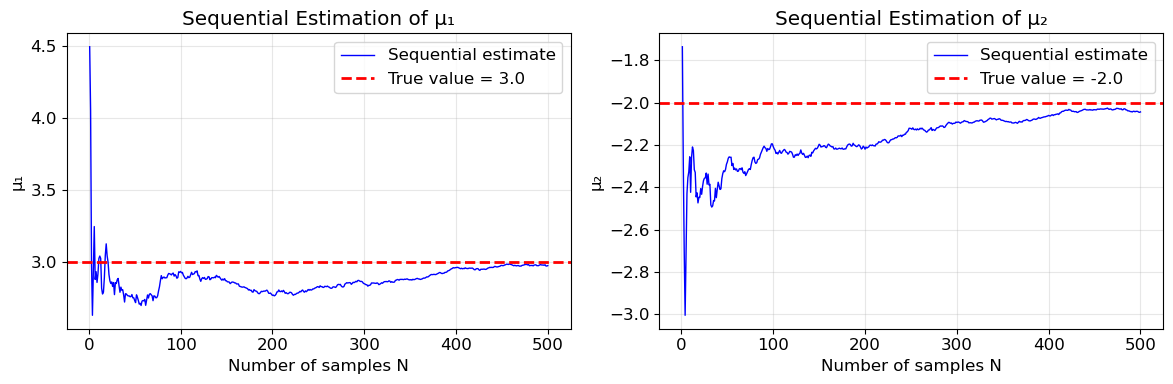


Final sequential estimate: [ 2.9742294  -2.04301678]
Batch MLE estimate:        [ 2.9742294  -2.04301678]
(These should match!)


In [57]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
nvals = np.arange(1, N5 + 1)

labels = ['\u03bc\u2081', '\u03bc\u2082']
for i, (ax, lab) in enumerate(zip(axes, labels)):
    ax.plot(nvals, mu_hist[:, i], 'b-', lw=1, label='Sequential estimate')
    ax.axhline(true_mean_5[i], color='r', ls='--', lw=2,
               label=f'True value = {true_mean_5[i]}')
    ax.set_xlabel('Number of samples N')
    ax.set_ylabel(lab)
    ax.set_title(f'Sequential Estimation of {lab}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('activity5_sequential.png', dpi=150)
plt.show()

print(f'\nFinal sequential estimate: {mu_hist[-1]}')
print(f'Batch MLE estimate:        {mu_ML_5}')
print('(These should match!)')

## Discussion

The sequential estimator gives exactly the same answer as the batch MLE, as expected. Looking at the convergence plots, the estimate jumps around a lot in the beginning when $N$ is small but then settles down and stays close to the true value as we get more data. This is basically the law of large numbers in action.

About the bias in $\boldsymbol{\Sigma}_{ML}$: same story as the 1D case. We lose one degree of freedom because we estimated $\boldsymbol{\mu}$ from the same data. The fix is dividing by $N-1$ (Bessel's correction). For $N = 500$ the correction factor is $499/500 = 0.998$ so it barely matters.

One thing that is worth mentioning is that unbiased is not always the best thing to aim for. Sometimes a biased estimator can actually have smaller mean squared error (MSE = bias$^2$ + variance) than an unbiased one. This is the bias-variance tradeoff that will come up again in the regression modules.

---

# Activity 6: Likelihood Shape and Parameter Uncertainty

The idea here is that the width of the likelihood function tells you how well the parameter is determined. Narrow peak = small uncertainty, broad peak = large uncertainty.

For a Gaussian with known $\sigma$, the log-likelihood as a function of $\mu$ is a parabola:

$$\ln \mathcal{L}(\mu) = \text{const} - \frac{N}{2\sigma^2}(\mu - \bar{x})^2$$

The curvature is $-N/\sigma^2$, which gives uncertainty $\sigma_\mu = \sigma/\sqrt{N}$.

The standard convention is that $\Delta \ln \mathcal{L} = -1/2$ defines the 1$\sigma$ confidence interval.

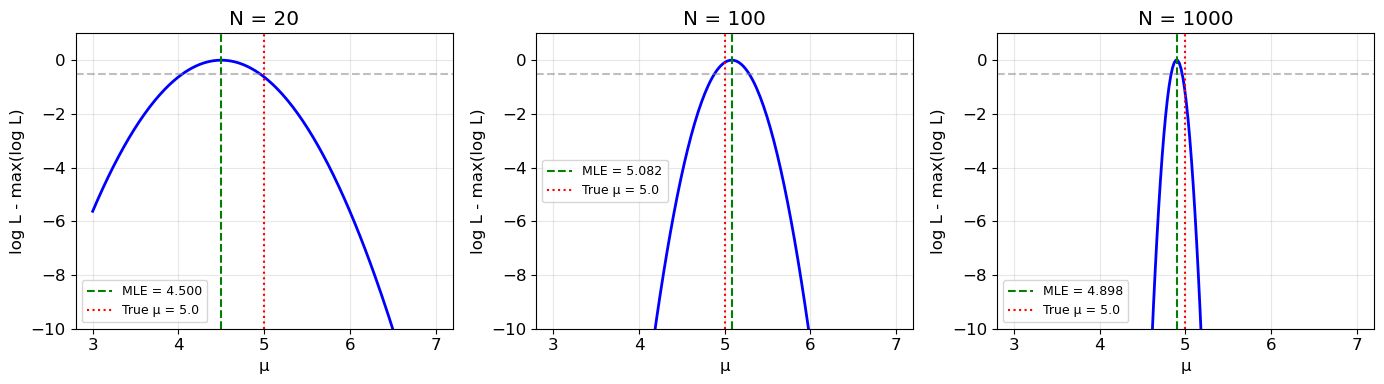

In [58]:
true_mu_6 = 5.0
true_sigma_6 = 2.0

def log_lik(mu_trial, data, sigma):
    N = len(data)
    return -N/2 * np.log(2*np.pi*sigma**2) - np.sum((data - mu_trial)**2) / (2*sigma**2)

sample_sizes = [20, 100, 1000]
mu_grid = np.linspace(3, 7, 200)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, Ns in zip(axes, sample_sizes):
    samp = np.random.normal(true_mu_6, true_sigma_6, size=Ns)
    ll = np.array([log_lik(m, samp, true_sigma_6) for m in mu_grid])
    ll = ll - np.max(ll)

    mu_hat = np.mean(samp)
    ax.plot(mu_grid, ll, 'b-', lw=2)
    ax.axvline(mu_hat, color='green', ls='--', label=f'MLE = {mu_hat:.3f}')
    ax.axvline(true_mu_6, color='red', ls=':', label=f'True \u03bc = {true_mu_6}')
    ax.axhline(-0.5, color='gray', ls='--', alpha=0.5)

    ax.set_xlabel('\u03bc')
    ax.set_ylabel('log L - max(log L)')
    ax.set_title(f'N = {Ns}')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-10, 1)

plt.tight_layout()
plt.savefig('activity6_likelihood.png', dpi=150)
plt.show()

In [59]:
print('Uncertainty in \u03bc as function of N:')
print('-' * 55)
print(f'{"N":>6} {"\u03c3_\u03bc (theory)":>18} {"\u03c3_\u03bc (empirical)":>22}')
print('-' * 55)

for Ns in [20, 100, 1000]:
    sig_mu_th = true_sigma_6 / np.sqrt(Ns)
    mu_ests = [np.mean(np.random.normal(true_mu_6, true_sigma_6, Ns)) for _ in range(10000)]
    sig_mu_emp = np.std(mu_ests)
    print(f'{Ns:>6} {sig_mu_th:>18.4f} {sig_mu_emp:>22.4f}')

print('\nThe uncertainty scales as 1/\u221aN, as expected!')

Uncertainty in μ as function of N:
-------------------------------------------------------
     N       σ_μ (theory)        σ_μ (empirical)
-------------------------------------------------------
    20             0.4472                 0.4487
   100             0.2000                 0.2007
  1000             0.0632                 0.0622

The uncertainty scales as 1/√N, as expected!


## Discussion

You can really see the difference in the three panels. For $N=20$ the log-likelihood is a pretty wide parabola, meaning we dont know $\mu$ very precisely. For $N=1000$ its a very sharp spike centered almost exactly on the true value.

The table confirms that $\sigma_\mu = \sigma/\sqrt{N}$ works. The empirical values match the theory to about 4 significant figures. So to cut the error bar in half, you need 4 times the data, which is kind of expensive in terms of beam time or detector operation.

The gray dashed line at $\Delta \ln \mathcal{L} = -1/2$ is the standard way to read off confidence intervals from a likelihood curve. Where it intersects gives you the $\pm 1\sigma$ range.

---

# Activity 7: Bayesian Inference for Gaussian Parameters

## Part 1: Known $\sigma^2$, infer $\mu$

In the Bayesian approach we treat $\mu$ as a random variable and put a prior on it. Then we use Bayes theorem to update our belief after seeing data:

$$p(\mu | \text{data}) \propto p(\text{data} | \mu) \cdot p(\mu)$$

If we pick a Gaussian prior $p(\mu) = \mathcal{N}(\mu_0, \sigma_0^2)$ and the likelihood is Gaussian with known $\sigma^2$, then the posterior turns out to also be Gaussian. This is the **conjugate prior** property -- the posterior stays in the same family as the prior, which makes everything analytically tractable.

The posterior is $p(\mu | \{x_n\}) = \mathcal{N}(\mu_N, \sigma_N^2)$ with:

$$\frac{1}{\sigma_N^2} = \frac{1}{\sigma_0^2} + \frac{N}{\sigma^2}$$

$$\mu_N = \sigma_N^2 \left(\frac{\mu_0}{\sigma_0^2} + \frac{N\bar{x}}{\sigma^2}\right)$$

The way to read this is that precisions (inverse variances) add up, and the posterior mean is just a precision-weighted average of the prior mean and the data mean. When $N$ is large the data term dominates and $\mu_N \to \bar{x}$, so we recover the MLE.

In [60]:
true_mu_7 = 5.0
known_sigma_7 = 2.0

mu_prior = 0.0
sigma_prior = 3.0

np.random.seed(42)
all_data_7 = np.random.normal(true_mu_7, known_sigma_7, size=200)

def bayesian_update_mean(data, mu0, sig0, sig):
    N = len(data)
    xbar = np.mean(data)
    sig_N_sq = 1.0 / (1.0/sig0**2 + N/sig**2)
    sig_N = np.sqrt(sig_N_sq)
    mu_N = sig_N_sq * (mu0/sig0**2 + N*xbar/sig**2)
    return mu_N, sig_N

Nvals_7 = [1, 5, 10, 20, 50, 100, 200]
results_7 = []
for Nv in Nvals_7:
    d = all_data_7[:Nv]
    mn, sn = bayesian_update_mean(d, mu_prior, sigma_prior, known_sigma_7)
    results_7.append({'N': Nv, 'mu_N': mn, 'sigma_N': sn, 'mu_ML': np.mean(d)})

print('Bayesian vs MLE for \u03bc (known \u03c3\u00b2):')
print('-' * 62)
print(f'{"N":>6} {"\u03bc_posterior":>14} {"\u03c3_posterior":>16} {"\u03bc_ML":>10}')
print('-' * 62)
for r in results_7:
    print(f'{r["N"]:>6} {r["mu_N"]:>14.4f} {r["sigma_N"]:>16.4f} {r["mu_ML"]:>10.4f}')
print(f'\nTrue \u03bc = {true_mu_7}')

Bayesian vs MLE for μ (known σ²):
--------------------------------------------------------------
     N    μ_posterior      σ_posterior       μ_ML
--------------------------------------------------------------
     1         4.1493           1.6641     5.9934
     5         5.4349           0.8571     5.9180
    10         5.6452           0.6189     5.8961
    20         4.5562           0.4423     4.6574
    50         4.5090           0.2816     4.5491
   100         4.7711           0.1996     4.7923
   200         4.9076           0.1413     4.9185

True μ = 5.0


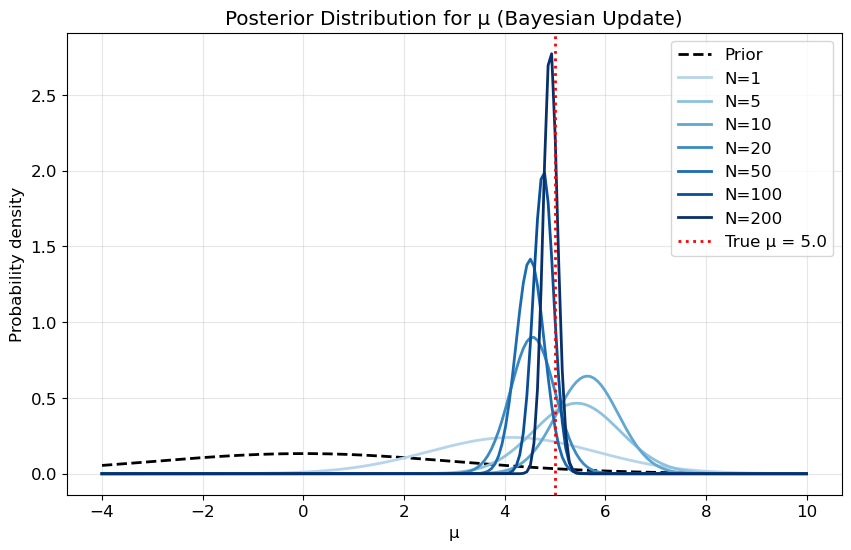

In [61]:
fig, ax = plt.subplots(figsize=(10, 6))
mu_grid_7 = np.linspace(-4, 10, 200)

ax.plot(mu_grid_7, stats.norm.pdf(mu_grid_7, mu_prior, sigma_prior),
        'k--', lw=2, label='Prior')

cmap = plt.cm.Blues(np.linspace(0.3, 1, len(results_7)))
for r, c in zip(results_7, cmap):
    pdf = stats.norm.pdf(mu_grid_7, r['mu_N'], r['sigma_N'])
    ax.plot(mu_grid_7, pdf, color=c, lw=2, label=f'N={r["N"]}')

ax.axvline(true_mu_7, color='red', ls=':', lw=2, label=f'True \u03bc = {true_mu_7}')
ax.set_xlabel('\u03bc')
ax.set_ylabel('Probability density')
ax.set_title('Posterior Distribution for \u03bc (Bayesian Update)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.savefig('activity7_bayesian_mu.png', dpi=150)
plt.show()

## Part 2: Known $\mu$, infer $\sigma^2$

Now we flip it: $\mu$ is known and we want to infer the variance. Following Bishop (pages 97-99), its easier to work with the precision $\lambda = 1/\sigma^2$.

The conjugate prior for $\lambda$ is the **Gamma distribution**:

$$p(\lambda) = \text{Gam}(\lambda | a_0, b_0) = \frac{b_0^{a_0}}{\Gamma(a_0)} \lambda^{a_0 - 1} e^{-b_0 \lambda}$$

After $N$ observations the posterior is also Gamma with updated parameters:

$$a_N = a_0 + \frac{N}{2}, \qquad b_N = b_0 + \frac{1}{2}\sum_{n=1}^{N}(x_n - \mu)^2$$

The posterior mean for $\lambda$ is $a_N/b_N$, so our estimate of $\sigma^2$ is $b_N/a_N$.

In [62]:
known_mu_7b = 5.0
true_sigma_7b = 2.0
true_prec = 1.0 / true_sigma_7b**2

a0, b0 = 1.0, 1.0

def bayesian_update_precision(data, mu, a0, b0):
    N = len(data)
    aN = a0 + N / 2.0
    bN = b0 + 0.5 * np.sum((data - mu)**2)
    return aN, bN

Nvals_7b = [5, 10, 20, 50, 100]
results_7b = []
for Nv in Nvals_7b:
    d = all_data_7[:Nv]
    aN, bN = bayesian_update_precision(d, known_mu_7b, a0, b0)
    lam_mean = aN / bN
    lam_std = np.sqrt(aN) / bN
    var_ML = np.sum((d - known_mu_7b)**2) / Nv
    results_7b.append({'N': Nv, 'aN': aN, 'bN': bN,
                       'lam_mean': lam_mean, 'lam_std': lam_std,
                       'prec_ML': 1.0/var_ML})

print(f'Bayesian inference for precision \u03bb = 1/\u03c3\u00b2 (true \u03bb = {true_prec:.4f}):')
print('-' * 70)
print(f'{"N":>6} {"\u27e8\u03bb\u27e9_post":>14} {"\u03c3_\u03bb":>10} {"\u03bb_ML":>10}')
print('-' * 70)
for r in results_7b:
    print(f'{r["N"]:>6} {r["lam_mean"]:>14.4f} {r["lam_std"]:>10.4f} {r["prec_ML"]:>10.4f}')

Bayesian inference for precision λ = 1/σ² (true λ = 0.2500):
----------------------------------------------------------------------
     N       ⟨λ⟩_post        σ_λ       λ_ML
----------------------------------------------------------------------
     5         0.4916     0.2628     0.4085
    10         0.4160     0.1698     0.3725
    20         0.2957     0.0892     0.2763
    50         0.2841     0.0557     0.2762
   100         0.3064     0.0429     0.3022


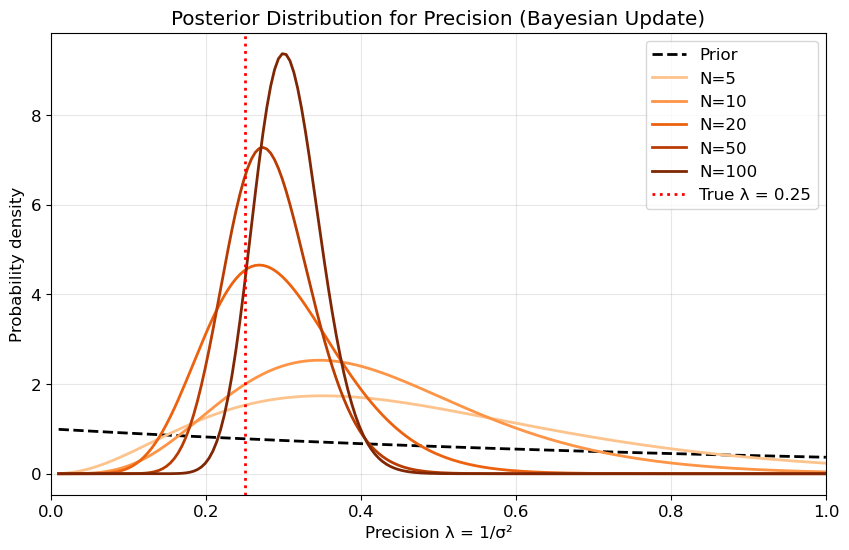

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))
lam_grid = np.linspace(0.01, 1.0, 200)

ax.plot(lam_grid, stats.gamma.pdf(lam_grid, a=a0, scale=1/b0),
        'k--', lw=2, label='Prior')

cmap2 = plt.cm.Oranges(np.linspace(0.3, 1, len(results_7b)))
for r, c in zip(results_7b, cmap2):
    pdf = stats.gamma.pdf(lam_grid, a=r['aN'], scale=1/r['bN'])
    ax.plot(lam_grid, pdf, color=c, lw=2, label=f'N={r["N"]}')

ax.axvline(true_prec, color='red', ls=':', lw=2, label=f'True \u03bb = {true_prec}')
ax.set_xlabel('Precision \u03bb = 1/\u03c3\u00b2')
ax.set_ylabel('Probability density')
ax.set_title('Posterior Distribution for Precision (Bayesian Update)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
plt.savefig('activity7_bayesian_precision.png', dpi=150)
plt.show()

## Discussion: Conjugate Priors

The whole conjugate prior idea is basically this: if you choose the right prior family, the posterior ends up in the same family. Thats very convenient because you get a closed-form answer, no need for numerical integration or sampling.

The other nice thing is that since the posterior has the same form as the prior, you can use today's posterior as tomorrow's prior when new data comes in. So you just keep updating the hyperparameters. This makes it naturally suited for sequential or online inference, like when you are calibrating a detector in real time.

Some common conjugate pairs:
- Gaussian likelihood (unknown $\mu$) + Gaussian prior = Gaussian posterior
- Gaussian likelihood (unknown $\lambda$) + Gamma prior = Gamma posterior
- Bernoulli likelihood + Beta prior = Beta posterior

From the plots we can see the posterior for $\mu$ starts out broad and centered near the prior mean, then gets taller and narrower and moves toward the true value as $N$ increases. Same for $\lambda$. Eventually both the Bayesian and MLE answers converge, which is expected since the prior gets washed out by enough data.

---

# Activity 8: Prior Sensitivity in Bayesian Mean Inference

Here we test what happens when we use two very different priors:
- **Narrow**: $\mathcal{N}(0, 0.5^2)$ -- very confident that $\mu \approx 0$ (which is wrong)
- **Broad**: $\mathcal{N}(0, 10^2)$ -- basically saying we have no idea

Both centered at 0, while the true $\mu$ is 5.

In [64]:
true_mu_8 = 5.0
known_sig_8 = 2.0

narrow = {'mu_0': 0.0, 'sigma_0': 0.5}
broad  = {'mu_0': 0.0, 'sigma_0': 10.0}

np.random.seed(123)
all_data_8 = np.random.normal(true_mu_8, known_sig_8, size=200)

def compare_priors(data, narrow, broad, sigma):
    mn_n, sn_n = bayesian_update_mean(data, narrow['mu_0'], narrow['sigma_0'], sigma)
    mn_b, sn_b = bayesian_update_mean(data, broad['mu_0'], broad['sigma_0'], sigma)
    return {
        'narrow': {'mu': mn_n, 'sigma': sn_n},
        'broad':  {'mu': mn_b, 'sigma': sn_b}
    }

Nvals_8 = [5, 20, 100, 200]

print('Prior sensitivity comparison:')
print('=' * 70)
print(f'Narrow prior: \u03bc\u2080 = {narrow["mu_0"]}, \u03c3\u2080 = {narrow["sigma_0"]}')
print(f'Broad prior:  \u03bc\u2080 = {broad["mu_0"]}, \u03c3\u2080 = {broad["sigma_0"]}')
print(f'True \u03bc = {true_mu_8}')
print('=' * 70)
print(f'\n{"N":>6} {"\u03bc_narrow":>12} {"\u03c3_narrow":>12} {"\u03bc_broad":>12} {"\u03c3_broad":>12}')
print('-' * 58)

results_8 = []
for Nv in Nvals_8:
    d = all_data_8[:Nv]
    res = compare_priors(d, narrow, broad, known_sig_8)
    res['N'] = Nv
    res['xbar'] = np.mean(d)
    results_8.append(res)
    print(f'{Nv:>6} {res["narrow"]["mu"]:>12.4f} {res["narrow"]["sigma"]:>12.4f}',
          f'{res["broad"]["mu"]:>12.4f} {res["broad"]["sigma"]:>12.4f}')

Prior sensitivity comparison:
Narrow prior: μ₀ = 0.0, σ₀ = 0.5
Broad prior:  μ₀ = 0.0, σ₀ = 10.0
True μ = 5.0

     N     μ_narrow     σ_narrow      μ_broad      σ_broad
----------------------------------------------------------
     5       1.0105       0.4364       4.2102       0.8909
    20       2.9049       0.3333       5.2184       0.4468
   100       4.3571       0.1857       5.0522       0.2000
   200       4.6366       0.1361       5.0066       0.1414


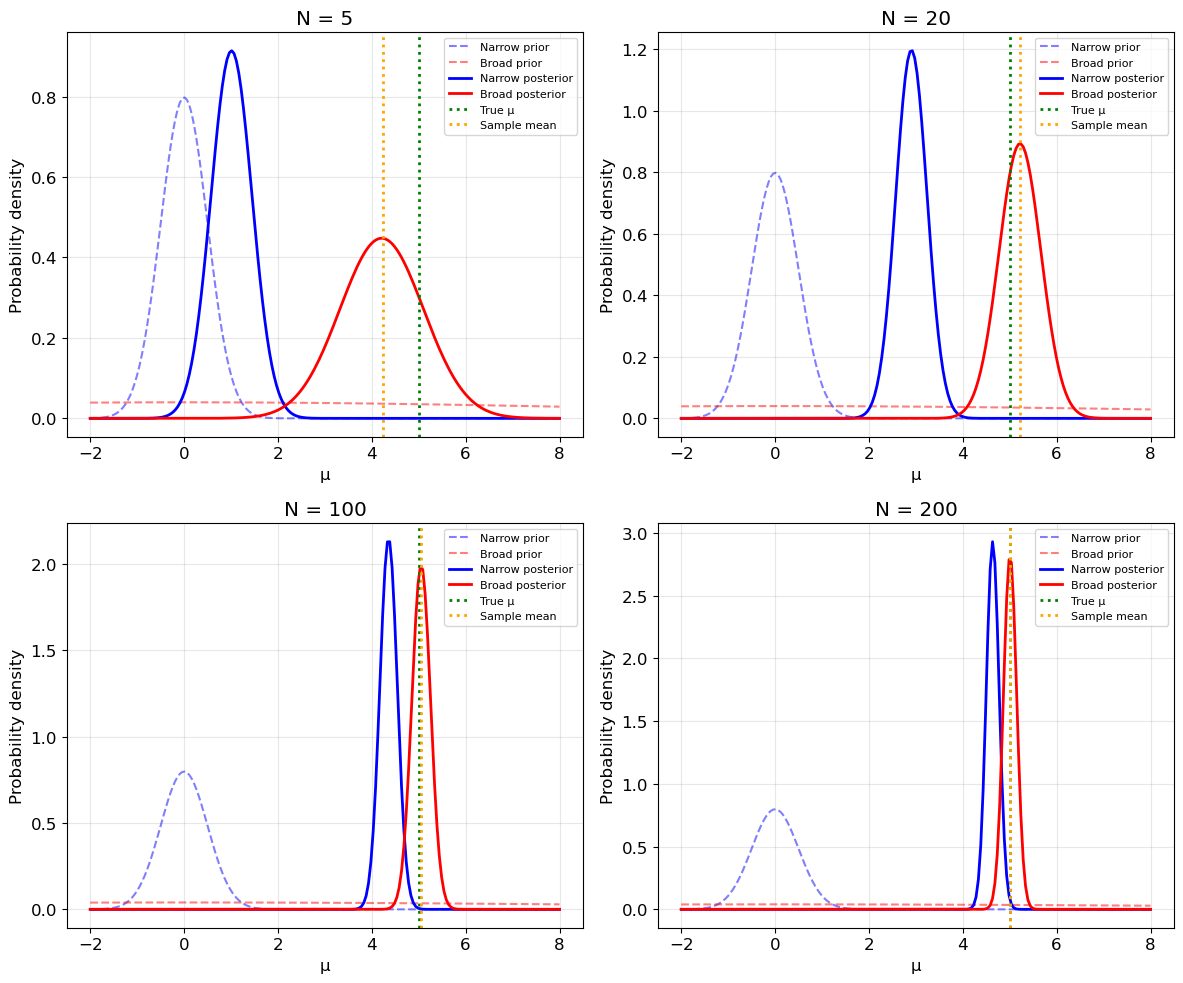

In [65]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
mu_grid_8 = np.linspace(-2, 8, 200)

for ax, r in zip(axes, results_8):
    Nv = r['N']

    ax.plot(mu_grid_8, stats.norm.pdf(mu_grid_8, narrow['mu_0'], narrow['sigma_0']),
            'b--', alpha=0.5, label='Narrow prior')
    ax.plot(mu_grid_8, stats.norm.pdf(mu_grid_8, broad['mu_0'], broad['sigma_0']),
            'r--', alpha=0.5, label='Broad prior')

    ax.plot(mu_grid_8, stats.norm.pdf(mu_grid_8, r['narrow']['mu'], r['narrow']['sigma']),
            'b-', lw=2, label='Narrow posterior')
    ax.plot(mu_grid_8, stats.norm.pdf(mu_grid_8, r['broad']['mu'], r['broad']['sigma']),
            'r-', lw=2, label='Broad posterior')

    ax.axvline(true_mu_8, color='green', ls=':', lw=2, label='True \u03bc')
    ax.axvline(r['xbar'], color='orange', ls=':', lw=2, label='Sample mean')

    ax.set_xlabel('\u03bc')
    ax.set_ylabel('Probability density')
    ax.set_title(f'N = {Nv}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('activity8_prior_sensitivity.png', dpi=150)
plt.show()

In [66]:
print('\nQuantifying prior influence:')
print('-' * 60)
print(f'{"N":>6} {"| \u03bc_narrow - \u03bc_broad |":>28} {"Rel. diff (%)":>15}')
print('-' * 60)

for r in results_8:
    diff = abs(r['narrow']['mu'] - r['broad']['mu'])
    rel = 100 * diff / true_mu_8
    print(f'{r["N"]:>6} {diff:>28.4f} {rel:>15.2f}')


Quantifying prior influence:
------------------------------------------------------------
     N       | μ_narrow - μ_broad |   Rel. diff (%)
------------------------------------------------------------
     5                       3.1998           64.00
    20                       2.3135           46.27
   100                       0.6951           13.90
   200                       0.3699            7.40


## Discussion

This is probably the most interesting result in this module. With only $N=5$ points, the narrow prior completely dominates -- it keeps the posterior stuck near $\mu = 0$ even though the data clearly says $\mu \approx 5$. The broad prior on the other hand lets the data speak, and the posterior is already close to the MLE. The difference between the two posteriors is about 64% which is huge.

As we add more data the gap shrinks. By $N=200$ both posteriors are basically on top of each other, both centered near the MLE. The narrow prior finally gave up and accepted what the data is saying.

Mathematically this makes sense. The posterior mean is a weighted average between the prior and the data:

$$\mu_N = \frac{\sigma^2/\sigma_0^2}{N + \sigma^2/\sigma_0^2}\,\mu_0 + \frac{N}{N + \sigma^2/\sigma_0^2}\,\bar{x}$$

For the narrow prior, $\sigma^2/\sigma_0^2 = 4/0.25 = 16$, so the prior acts like it has 16 "fake" data points worth of information. You need $N$ way bigger than 16 before the data takes over. For the broad prior, $\sigma^2/\sigma_0^2 = 4/100 = 0.04$, so even $N=1$ is enough for the data to win.

The practical takeaway: if you have a lot of data, it really does not matter what prior you use. But if you only have a few observations (like in rare decay searches or dark matter experiments), the prior can significantly affect your result. In that case you should think carefully about what prior to use, and probably go with something broad unless you have a really good reason not to.

---

# Summary

1. **CLT**: Averages of random variables become Gaussian. Explains why Gaussian errors are everywhere.
2. **Poisson**: For counting experiments, $\text{Var}(k) = \langle k \rangle = \lambda$, giving $\sigma = \sqrt{k}$ error bars.
3. **2D Gaussians**: Covariance matrix encodes correlations. Contours are ellipses.
4. **MLE**: $\mu_{ML} = \bar{x}$ (unbiased), $\sigma^2_{ML} = \frac{1}{N}\sum(x_n - \bar{x})^2$ (biased by $(N-1)/N$).
5. **Sequential estimation**: Same result as batch, but one point at a time.
6. **Likelihood width**: Scales as $\sigma/\sqrt{N}$. More data = narrower peak.
7. **Bayesian inference**: Conjugate priors give closed-form posteriors.
8. **Prior sensitivity**: Matters for small $N$, irrelevant for large $N$.